In [ ]:
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf

In [ ]:
# init spark session
spark = SparkSession.builder.master('local[*]').config('spark.ui.port', '4040').getOrCreate()
spark

# Exploratory Data Analysis

In [7]:
review_fp = "hdfs://namenode:9000/review_data/preprocessed"
df = spark.read.csv(review_fp, header=True, inferSchema=True)

df.printSchema()
print(f'Total reviews: {df.count()}')
df.show(5)

root
 |-- review: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- place_index: integer (nullable = true)
 |-- sentiment: string (nullable = true)

Total reviews: 3425
+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miếng gà 105k n...|     1|          0| negative|
|Gà ướp vừa vị , m...|     5|          0| positive|
|Thật tuyệt với gà...|     5|          0| positive|
|Quán sạch , đẹp ,...|     5|          0| positive|
|Nhân_viên bự con ...|     5|          0| positive|
+--------------------+------+-----------+---------+
only showing top 5 rows



In [11]:
# Total Rows & Columns
print(f"Total rows: {df.count()}")
print(f"Total columns: {len(df.columns)}\n")

print('Overview of columns:')
df.describe().show()

print('Count by rating:')
df.groupBy('rating').count().orderBy('rating').show()

Total rows: 3425
Total columns: 4

Overview of columns:
+-------+--------------------+------------------+-----------------+---------+
|summary|              review|            rating|      place_index|sentiment|
+-------+--------------------+------------------+-----------------+---------+
|  count|                3425|              3425|             3425|     3425|
|   mean|                NULL| 4.258978102189781|8.811678832116788|     NULL|
| stddev|                NULL|1.4544572187638496|5.209891653545296|     NULL|
|    min|( không chỉ chi_n...|                 1|                0| negative|
|    max|               🥳 🙌|                 5|               17| positive|
+-------+--------------------+------------------+-----------------+---------+

Count by rating:
+------+-----+
|rating|count|
+------+-----+
|     1|  496|
|     2|   68|
|     3|  113|
|     4|  124|
|     5| 2624|
+------+-----+



# **Visualization**

## *Distribution of ratings*

Based on the chart, it’s clear that most users gave 5-star ratings (**2624 reviews**), showing that they were really satisfied with the service.\
The number of lower ratings like 1 (**496 reviews**), 2 (**68 reviews**), or 3 (**113 reviews**) stars is quite small in comparison, implying that only a few people had negative experiences.

The strong concentration in high ratings suggests that the overall user feedback is very positive.

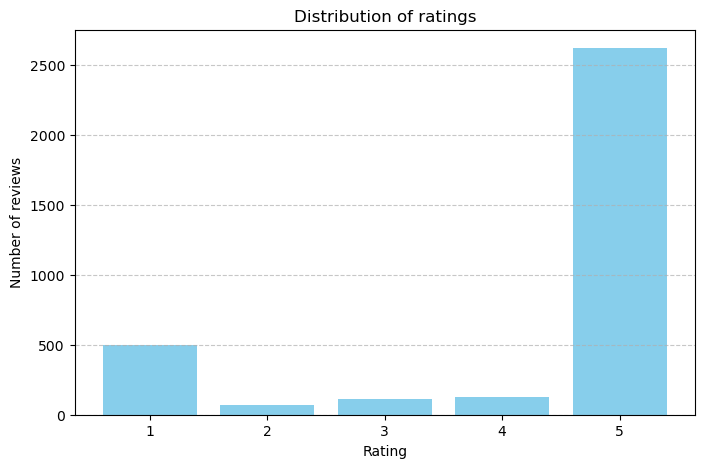

In [ ]:
rating_distribution = df.groupBy('rating').count().orderBy('rating')

data = rating_distribution.collect()
ratings = [row['rating'] for row in data]
counts = [row['count'] for row in data]

plt.figure(figsize=(8, 5))
plt.title('Distribution of ratings')

plt.bar(ratings, counts, color='skyblue')

plt.xlabel('Rating')
plt.xticks(ratings)
plt.ylabel('Number of reviews')

plt.grid(axis='y', linestyle='--', alpha=0.7);

## `place_index` *by average rating*

From the chart, we can see that the average ratings across different places are generally high, most of them above 4.\
This shows that users tend to be quite satisfied overall. Place index 7 stands out with the highest average, close to 5 stars, while place 8 has the lowest, of below 4 stars.

The moderate variation between places suggests that service quality is fairly consistent, though some places clearly perform better than others.

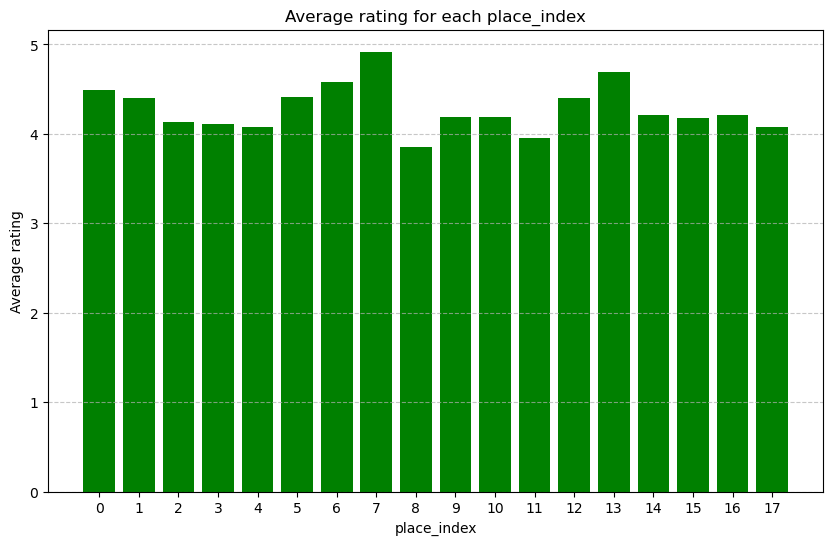

In [30]:
place_index_rating_avg = df.groupBy('place_index').avg('rating').orderBy('place_index')

data = place_index_rating_avg.collect()
place_indices = [row['place_index'] for row in data]
avg_ratings = [row['avg(rating)'] for row in data]

plt.figure(figsize=(10, 6))
plt.bar(place_indices, avg_ratings, color='green')
plt.xlabel('place_index')
plt.ylabel('Average rating')
plt.title('Average rating for each place_index')
plt.xticks(place_indices)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Word Count**

To better understand the common themes in the reviews, we analyzed the commonly used words within the reviews.

In [16]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import explode, split, lower, regexp_replace, col, desc, length

The list of Vietnamese stopwords are provided by [`stopwords/vietnamese-stopwords`](https://github.com/stopwords/vietnamese-stopwords)

In [12]:
!wget -O vietnamese-stopwords-dash.txt https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/refs/heads/master/vietnamese-stopwords-dash.txt

--2025-04-29 05:40:54--  https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/refs/heads/master/vietnamese-stopwords-dash.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20475 (20K) [text/plain]
Saving to: ‘vietnamese-stopwords-dash.txt’

vietnamese-stopword 100%[===================>]  20.00K  --.-KB/s    in 0.004s  

2025-04-29 05:40:55 (4.44 MB/s) - ‘vietnamese-stopwords-dash.txt’ saved [20475/20475]



In [13]:
stopwords_path = "vietnamese-stopwords-dash.txt"
with open(stopwords_path, encoding='utf-8') as file:
    stopwords = [line.strip() for line in file]

In [ ]:
df_clean = df.withColumn(
    "clean_review",
    regexp_replace(
        lower(col("review")),
        "[^a-zA-Z\\sàáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ]",
        ""
    )
)

word_counts = df_clean.select(
    explode(split(col("clean_review"), " ")).alias("word")
).filter(
    (col("word") != "") &
    (~col("word").isin(stopwords))
).groupBy("word").count().orderBy(desc("count"))

In [17]:
df_clean = df.withColumn(
    "clean_review",
    regexp_replace(
        lower(col("review")),
        "[^a-zA-Z\\sàáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ]",
        ""
    )
)

The word frequency table shows that users often mention aspects related to service quality and food. Words like 'nhânviên', 'phụcvụ', 'nhiệttình', 'thânthiện', and 'dễthương' appear frequently, indicating a generally positive impression of customer service. In terms of food, words such as 'ngon', 'gà', 'giòn', 'món', and 'chiên' suggest that many users were satisfied with the food quality, especially chicken – a key product of KFC. Some negative or neutral words like 'tệ', 'đợi', 'ko', and 'k' also appear, but with lower frequency, implying that negative experiences exist but are not dominant.

In [ ]:
print("Top keywords:")
word_counts.show(50, truncate=False)

Top các từ phổ biến nhất:
+---------+-----+
|word     |count|
+---------+-----+
|nhânviên |1587 |
|ngon     |1305 |
|gà       |938  |
|đồ       |836  |
|nhiệttình|660  |
|phụcvụ   |556  |
|món      |427  |
|kfc      |395  |
|thânthiện|370  |
|quán     |366  |
|dễthương |363  |
|khônggian|289  |
|sạchsẽ   |274  |
|ko       |258  |
|k        |243  |
|đi       |233  |
|giòn     |233  |
|tháiđộ   |208  |
|tệ       |185  |
|mua      |185  |
|đợi      |177  |
|nóng     |172  |
|nv       |171  |
|nhàhàng  |171  |
|dịchvụ   |154  |
|ghé      |153  |
|nghiệm   |151  |
|vuivẻ    |145  |
|trải     |140  |
|nha      |138  |
|đơn      |134  |
|lắm      |134  |
|hơi      |131  |
|order    |131  |
|thoáng   |128  |
|mát      |128  |
|kháchhàng|127  |
|chinhánh |124  |
|miếng    |123  |
|giao     |122  |
|ok       |120  |
|rán      |117  |
|đông     |114  |
|quảnlý   |113  |
|combo    |113  |
|gọi      |109  |
|tuyệtvời |104  |
|chỗ      |100  |
|mấy      |100  |
|chiên    |97   |
+---------+-----+
on

# WordCloud

Wordcloud is a visualization tool that displays the frequency of words in a text dataset. This section uses the Python library wordcloud to create a Wordcloud image from customer's reviews 

In [35]:
!pip install wordcloud

In [58]:
from wordcloud import WordCloud

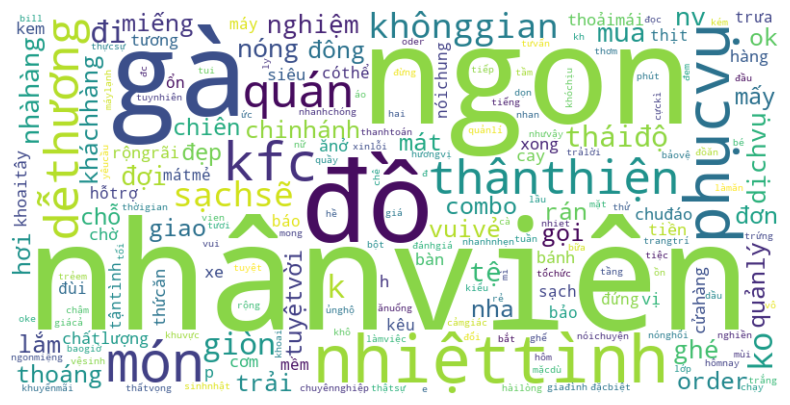

In [59]:
word_counts_data = word_counts.collect()
word_freq = {row['word']: row['count'] for row in word_counts_data}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Count by Sentiment

The word count for each sentiment (negative, postitive, neural) is examined to identify the most frequent terms associated with that sentiment. The table below displays the top words appearing most often in negative sentiment expressions, along with their respective frequency counts

In [60]:
import pyspark.sql.functions as F

wc_sen = df_clean.select(
    explode(split(col('clean_review'), ' ')).alias('word'),
    col('sentiment')
).filter(
    (col('word') != '') & 
    (~col('word').isin(stopwords))
).groupBy('sentiment', 'word').count().orderBy('sentiment', F.desc('count'))

wc_sen.show(50, truncate=False)


+---------+---------+-----+
|sentiment|word     |count|
+---------+---------+-----+
|negative |nhânviên |368  |
|negative |gà       |339  |
|negative |ko       |194  |
|negative |k        |182  |
|negative |tệ       |169  |
|negative |tháiđộ   |166  |
|negative |đồ       |155  |
|negative |kfc      |149  |
|negative |đợi      |144  |
|negative |món      |135  |
|negative |đi       |127  |
|negative |quán     |126  |
|negative |mua      |119  |
|negative |đơn      |113  |
|negative |giao     |99   |
|negative |order    |96   |
|negative |phụcvụ   |84   |
|negative |gọi      |84   |
|negative |xong     |78   |
|negative |p        |78   |
|negative |miếng    |77   |
|negative |chinhánh |74   |
|negative |kháchhàng|72   |
|negative |combo    |72   |
|negative |tiền     |72   |
|negative |chiên    |66   |
|negative |nv       |66   |
|negative |h        |65   |
|negative |quảnlý   |63   |
|negative |chờ      |61   |
|negative |hàng     |57   |
|negative |tương    |57   |
|negative |khoaitây 

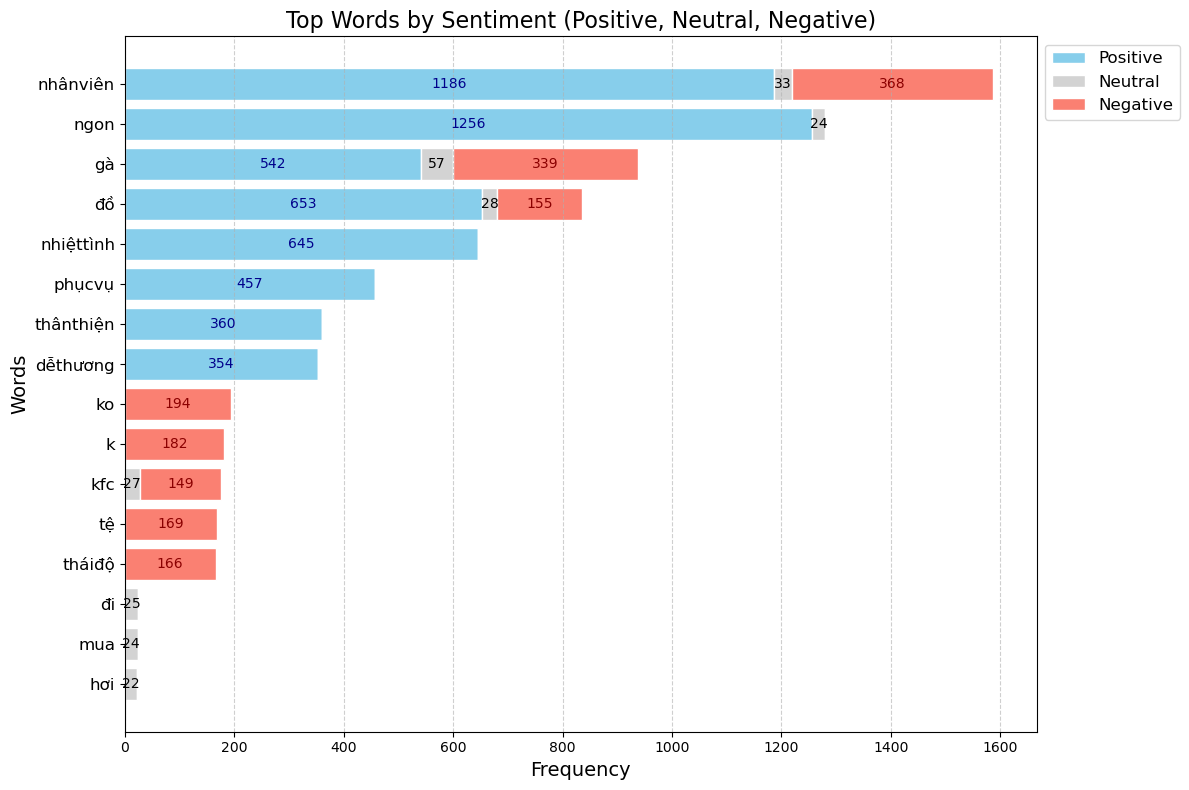

In [82]:
# Convert to Pandas
pd_word_counts = wc_sen.toPandas()

top_words = {}
sentiments = ['positive', 'neutral', 'negative']

for sentiment in sentiments:
    top_words[sentiment] = (
        pd_word_counts[pd_word_counts['sentiment'] == sentiment]
        .nlargest(8, 'count')[['word', 'count']]
        .set_index('word')['count']
        .to_dict()
    )

all_words = list(set(
    list(top_words['positive'].keys()) + 
    list(top_words['neutral'].keys()) + 
    list(top_words['negative'].keys())
))

df_plot = pd.DataFrame({
    'Word': all_words,
    'Positive': [top_words['positive'].get(word, 0) for word in all_words],
    'Neutral': [top_words['neutral'].get(word, 0) for word in all_words],
    'Negative': [top_words['negative'].get(word, 0) for word in all_words]
})

df_plot['Total'] = df_plot['Positive'] + df_plot['Neutral'] + df_plot['Negative']
df_plot = df_plot.sort_values('Total', ascending=True)

# Visualize stacked bar
plt.figure(figsize=(12, 8))

p1 = plt.barh(df_plot['Word'], df_plot['Positive'], 
              color='skyblue', label='Positive', edgecolor='white')
p2 = plt.barh(df_plot['Word'], df_plot['Neutral'], 
              left=df_plot['Positive'],
              color='lightgray', label='Neutral', edgecolor='white')
p3 = plt.barh(df_plot['Word'], df_plot['Negative'], 
              left=df_plot['Positive'] + df_plot['Neutral'],
              color='salmon', label='Negative', edgecolor='white')

for i, word in enumerate(df_plot['Word']):
    # Positive
    if df_plot['Positive'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i]/2, i,
                str(df_plot['Positive'].iloc[i]), 
                va='center', ha='center', color='darkblue', fontsize=10)
    
    # Neutral
    if df_plot['Neutral'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i]/2, i,
                str(df_plot['Neutral'].iloc[i]), 
                va='center', ha='center', color='black', fontsize=10)
    
    # Negative
    total_width = df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i] + df_plot['Negative'].iloc[i]
    if df_plot['Negative'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i] + df_plot['Negative'].iloc[i]/2, i,
                str(df_plot['Negative'].iloc[i]), 
                va='center', ha='center', color='darkred', fontsize=10)

plt.yticks(range(len(df_plot['Word'])), df_plot['Word'], fontsize=12)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('Top Words by Sentiment (Positive, Neutral, Negative)', fontsize=16)
plt.legend(fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Word Count by Rating

In [53]:
wc_rating = df_clean.select(
    explode(split(col('clean_review'), ' ')).alias('word'),
    col('rating')
).filter(
    (col('word') != '') & 
    (~col('word').isin(stopwords))
).groupBy('rating', 'word').count().orderBy('rating', F.desc('count'))

wc_rating.show(50, truncate=False)


+------+---------+-----+
|rating|word     |count|
+------+---------+-----+
|1     |nhânviên |328  |
|1     |gà       |279  |
|1     |ko       |182  |
|1     |k        |164  |
|1     |tệ       |154  |
|1     |tháiđộ   |143  |
|1     |đồ       |131  |
|1     |đợi      |130  |
|1     |kfc      |124  |
|1     |món      |120  |
|1     |quán     |113  |
|1     |đơn      |109  |
|1     |đi       |104  |
|1     |mua      |104  |
|1     |order    |91   |
|1     |giao     |86   |
|1     |phụcvụ   |76   |
|1     |p        |72   |
|1     |xong     |70   |
|1     |gọi      |69   |
|1     |miếng    |68   |
|1     |chinhánh |66   |
|1     |tiền     |66   |
|1     |combo    |62   |
|1     |kháchhàng|60   |
|1     |quảnlý   |59   |
|1     |chiên    |59   |
|1     |chờ      |58   |
|1     |h        |57   |
|1     |kêu      |53   |
|1     |đứng     |50   |
|1     |hàng     |49   |
|1     |tương    |48   |
|1     |khoaitây |48   |
|1     |nghiệm   |47   |
|1     |nv       |46   |
|1     |cơm      |44   |


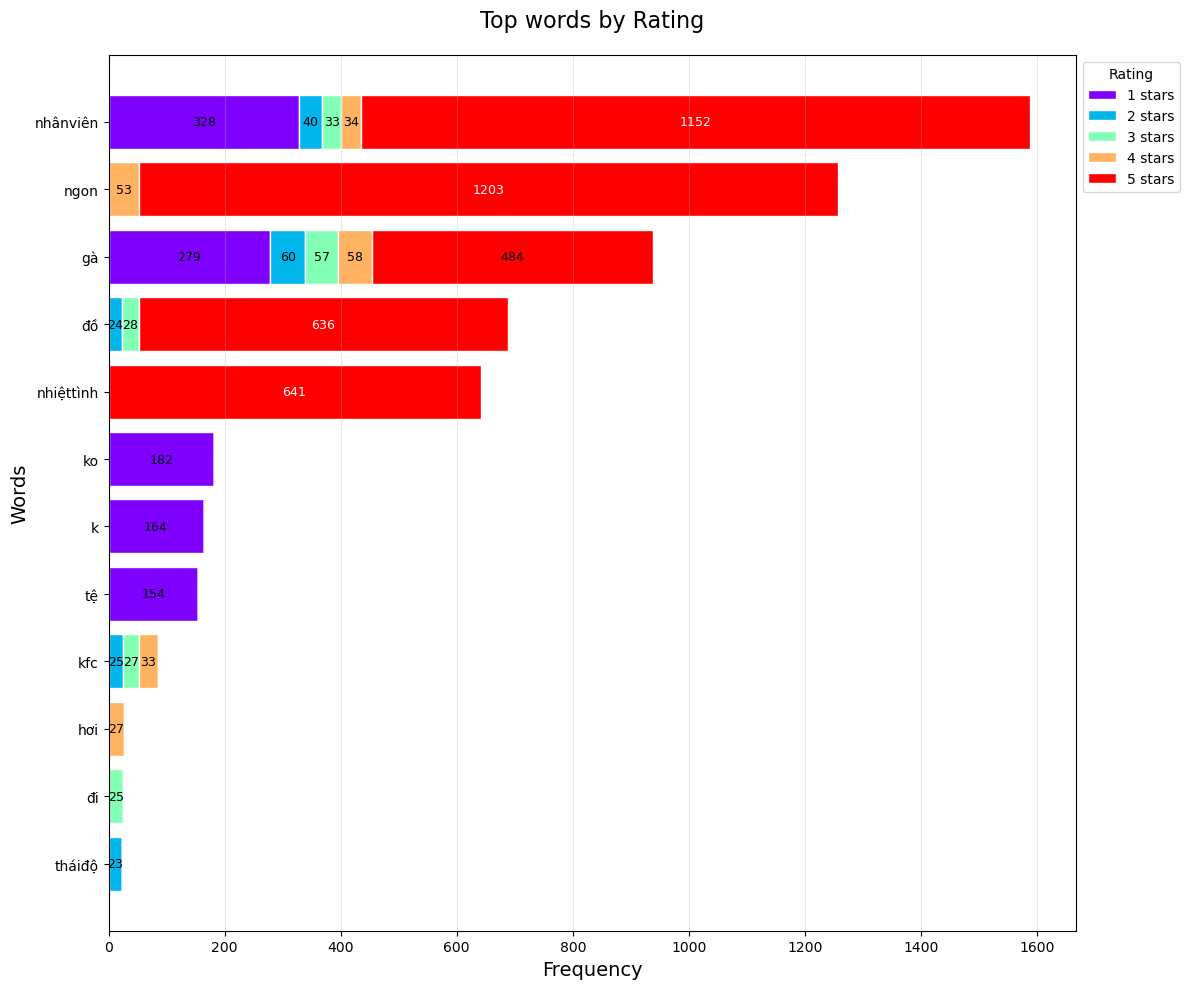

In [80]:
# Convert to Pandas
pd_rating = wc_rating.toPandas()

# Top words
top_words = {}
for rating in [1, 2, 3, 4, 5]:
    top_words[rating] = (
        pd_rating[pd_rating['rating'] == rating]
        .nlargest(5, 'count')[['word', 'count']]
        .set_index('word')['count']
    )

all_words = list(set(
    list(top_words[1].keys()) + 
    list(top_words[2].keys()) + 
    list(top_words[3].keys()) + 
    list(top_words[4].keys()) + 
    list(top_words[5].keys())
))

df_plot = pd.DataFrame({'word': all_words})
for rating in [1, 2, 3, 4, 5]:
    df_plot[f'rating_{rating}'] = [top_words[rating].get(word, 0) for word in all_words]


df_plot['total'] = df_plot[[f'rating_{r}' for r in [1,2,3,4,5]]].sum(axis=1)
df_plot = df_plot.sort_values('total', ascending=True)

# Visualize stacked chart
plt.figure(figsize=(12, 10))
colors = plt.cm.rainbow(np.linspace(0, 1, 5))

left = None
for idx, rating in enumerate([1, 2, 3, 4, 5]):
    plt.barh(
        df_plot['word'],
        df_plot[f'rating_{rating}'],
        color=colors[idx],
        label=f'{rating} stars',
        left=left,
        edgecolor='white'
    )
    left = df_plot[f'rating_{rating}'] if left is None else left + df_plot[f'rating_{rating}']

for i, word in enumerate(df_plot['word']):
    width = 0
    for rating in [1, 2, 3, 4, 5]:
        value = df_plot[f'rating_{rating}'].iloc[i]
        if value > 0:
            plt.text(
                width + value/2, i,
                str(int(value)), 
                va='center', ha='center',
                color='white' if value > max(df_plot[[f'rating_{r}' for r in [1,2,3,4,5]]].max())/2 else 'black',
                fontsize=9
            )
            width += value

plt.title('Top words by Rating', fontsize=16, pad=20)
plt.ylabel('Words', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.legend(title='Rating', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()